In [2]:
from astropy.table import Table
import astropy.cosmology as apc
import numpy as np
import matplotlib.pyplot as plt
import h5py

%matplotlib inline

287750
number of QSO 0
number of GALAXY 287750


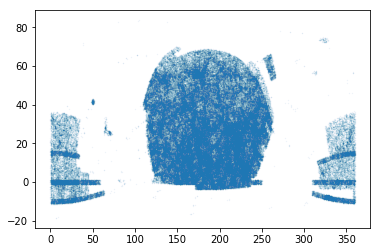

In [4]:
data = Table.read("../sdss_dr15/skyserver_results.fits")
print(len(data))
print('number of QSO', len(data[data['class']=='QSO']))
print('number of GALAXY', len(data[data['class']=='GALAXY']))
ii_gal = data['class']=='GALAXY'
gal_data = data[ii_gal]
plt.scatter(gal_data['ra'], gal_data['dec'], alpha=0.1, s=0.1)

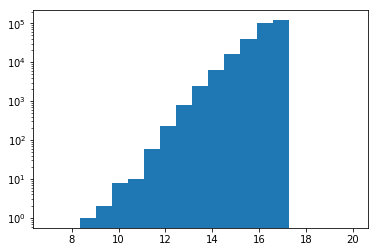

In [5]:
_ = plt.hist(gal_data['r'], bins=np.linspace(7,20,20), log=True)

198


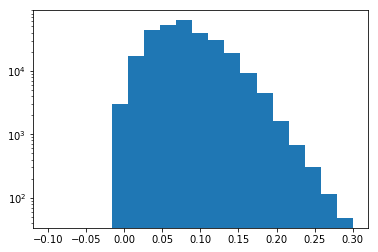

In [6]:
_ = plt.hist(gal_data['redshift'], bins=np.linspace(-0.1,0.3,20), log=True)
print(np.count_nonzero(gal_data['redshift']<0.0))

In [12]:
def write_data_set(gal_data, cosmology, cosmology_name='Planck15'):
    gal_data['theta'] = np.deg2rad(90-gal_data['dec'])
    gal_data['phi'] = np.deg2rad((gal_data['ra'] - (90+45))%360.0)
    gal_data['r_comoving'] = cosmology.comoving_distance(gal_data['redshift'])
    gal_data['z_coord'] = gal_data['r_comoving'] * np.cos(gal_data['theta'])
    gal_data['y_coord'] = gal_data['r_comoving'] * np.sin(gal_data['theta']) * np.sin(gal_data['phi'])
    gal_data['x_coord'] = gal_data['r_comoving'] * np.sin(gal_data['theta']) * np.cos(gal_data['phi'])
    ii_mask = (gal_data['theta'] < np.pi/2)  
    ii_mask &= (gal_data['theta']>np.pi/4) 
    ii_mask &= (gal_data['phi']>0.0) 
    ii_mask &= (gal_data['phi']<np.pi/2.0) 
    ii_mask &= (gal_data['r_comoving']>0.0)
    ii_mask &= (gal_data['r_comoving']<300.0)
    gal_data_mask = gal_data[ii_mask]

    print(len(gal_data_mask))
    output_filename = '../sdss_dr15/{}_SDSS_corner_cartesian.hdf5'.format(cosmology_name)
    h5f = h5py.File(output_filename, 'w')
    h5f.create_dataset('u', data=gal_data_mask['u'])
    h5f.create_dataset('g', data=gal_data_mask['g'])
    h5f.create_dataset('r', data=gal_data_mask['r'])
    h5f.create_dataset('z_coord', data=gal_data_mask['z_coord'])
    h5f.create_dataset('y_coord', data=gal_data_mask['y_coord'])
    h5f.create_dataset('x_coord', data=gal_data_mask['x_coord'])
    h5f.create_dataset('redshift', data=gal_data_mask['redshift'])
    h5f.create_dataset('r_comoving', data=gal_data_mask['r_comoving'])
    h5f.close()
    
    f = h5py.File(output_filename, 'r')
    x = f['x_coord'][:]
    y = f['y_coord'][:]
    z = f['z_coord'][:]
    f.close()
    pos = np.array([x,y,z])
    out_ascii_filename = '../sdss_dr15/{}_SDSS_corner_cartesian_pos.txt'.format(cosmology_name)
    np.savetxt(out_ascii_filename, pos.T)
    return gal_data_mask

In [13]:
# redefining coordinates
planck15 = apc.Planck15
planck15.H0
print(planck15.name, planck15.H0, planck15.Tcmb0)
gal_data_mask = write_data_set(gal_data, planck15, cosmology_name=planck15.name)
for omega_dm in np.linspace(0.1,1.0,10):
    for omega_de in np.linspace(0.1, 1.0, 10):
        name='omega_dm_{:.1f}_omega_de_{:.1f}'.format(omega_dm, omega_de)
        print(name)
        cosmo = apc.LambdaCDM(H0=planck15.H0, Om0=omega_dm, Ode0=omega_de, Tcmb0=planck15.Tcmb0, name=name)
        gal_data_mask = write_data_set(gal_data, cosmo, cosmology_name=cosmo.name)

Planck15 67.74 km / (Mpc s) 2.7255 K
53335
omega_dm_0.1_omega_de_0.1
54699
omega_dm_0.1_omega_de_0.2
54423
omega_dm_0.1_omega_de_0.3
54124
omega_dm_0.1_omega_de_0.4
53839
omega_dm_0.1_omega_de_0.5
53574
omega_dm_0.1_omega_de_0.6
53267
omega_dm_0.1_omega_de_0.7
52997
omega_dm_0.1_omega_de_0.8
52746
omega_dm_0.1_omega_de_0.9
52453
omega_dm_0.1_omega_de_1.0
52172
omega_dm_0.2_omega_de_0.1
54870
omega_dm_0.2_omega_de_0.2
54570
omega_dm_0.2_omega_de_0.3
54279
omega_dm_0.2_omega_de_0.4
53986
omega_dm_0.2_omega_de_0.5
53718
omega_dm_0.2_omega_de_0.6
53434
omega_dm_0.2_omega_de_0.7
53146
omega_dm_0.2_omega_de_0.8
52887
omega_dm_0.2_omega_de_0.9
52604
omega_dm_0.2_omega_de_1.0
52323
omega_dm_0.3_omega_de_0.1
55026
omega_dm_0.3_omega_de_0.2
54721
omega_dm_0.3_omega_de_0.3
54451
omega_dm_0.3_omega_de_0.4
54145
omega_dm_0.3_omega_de_0.5
53858
omega_dm_0.3_omega_de_0.6
53596
omega_dm_0.3_omega_de_0.7
53292
omega_dm_0.3_omega_de_0.8
53013
omega_dm_0.3_omega_de_0.9
52766
omega_dm_0.3_omega_de_1.0
524

Text(0,0.5,'z')

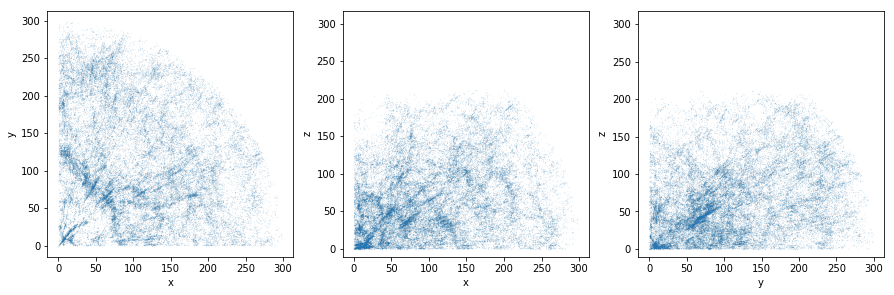

In [17]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
_ = plt.scatter(gal_data_mask['x_coord'], gal_data_mask['y_coord'], s=0.001)
plt.axis('square')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(1,3,2)
_ = plt.scatter(gal_data_mask['x_coord'], gal_data_mask['z_coord'], s=0.001)
plt.axis('square')
plt.xlabel('x')
plt.ylabel('z')

plt.subplot(1,3,3)
_ = plt.scatter(gal_data_mask['y_coord'], gal_data_mask['z_coord'], s=0.001)
plt.axis('square')
plt.xlabel('y')
plt.ylabel('z')

Text(0,0.5,'y')

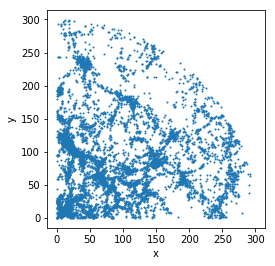

In [18]:
ii=gal_data_mask['z_coord']<20.0
plt.scatter(gal_data_mask['x_coord'][ii], gal_data_mask['y_coord'][ii], s=1.0)
plt.axis('square')
plt.xlabel('x')
plt.ylabel('y')

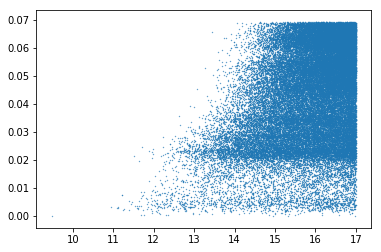

In [19]:
_ = plt.scatter(gal_data_mask['r'], gal_data_mask['redshift'], s=0.1)